# Setup

In [39]:
# dependencies
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, mean_squared_error, brier_score_loss
from scipy.interpolate import UnivariateSpline
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Process Data

## Regular Season

In [40]:
# import data
m_reg_detailed = pd.read_csv("data/MRegularSeasonDetailedResults.csv")

In [41]:
m_reg_detailed

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118877,2025,132,1196,86,1397,77,N,0,26,61,9,27,25,28,15,24,11,8,6,1,25,22,49,8,26,25,32,5,20,15,9,7,5,21
118878,2025,132,1272,84,1412,72,N,0,32,68,6,13,14,23,18,27,13,12,10,7,18,24,69,7,27,17,23,21,23,10,15,5,4,21
118879,2025,132,1276,59,1458,53,N,0,19,59,9,33,12,13,6,34,14,8,3,2,16,15,68,7,39,16,18,15,31,8,6,3,2,14
118880,2025,132,1433,68,1206,63,N,0,19,47,8,25,22,27,11,25,10,16,7,9,20,19,56,9,21,16,19,14,19,13,11,11,3,22


In [42]:
m_reg_winners = m_reg_detailed.copy()

winner_cols = {'WTeamID':'TeamID', 'WScore':'Pts', 'LTeamID':'Opp_TeamID', 'LScore':'Opp_Pts', 'WFGM':'FGM', 'WFGA':'FGA', 'WFGM3':'FGM3', 
               'WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA', 'WOR':'OR', 'WDR':'DR', 'WAst':'Ast', 'WTO':'TO', 'WStl': 'Stl', 'WBlk': 'Blk', 
               'WPF': 'PF', 'LFGM':'Opp_FGM', 'LFGA':'Opp_FGA', 'LFGM3':'Opp_FGM3', 'LFGA3':'Opp_FGA3', 'LFTM':'Opp_FTM', 'LFTA':'Opp_FTA', 
               'LOR':'Opp_OR', 'LDR':'Opp_DR', 'LAst':'Opp_Ast', 'LTO':'Opp_TO', 'LStl':'Opp_Stl', 'LBlk': 'Opp_Blk', 'LPF': 'Opp_PF'}

m_reg_winners= m_reg_winners.rename(columns=winner_cols)
m_reg_winners

,Season,DayNum,TeamID,Pts,Opp_TeamID,Opp_Pts,WLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118877,2025,132,1196,86,1397,77,N,0,26,61,9,27,25,28,15,24,11,8,6,1,25,22,49,8,26,25,32,5,20,15,9,7,5,21
118878,2025,132,1272,84,1412,72,N,0,32,68,6,13,14,23,18,27,13,12,10,7,18,24,69,7,27,17,23,21,23,10,15,5,4,21
118879,2025,132,1276,59,1458,53,N,0,19,59,9,33,12,13,6,34,14,8,3,2,16,15,68,7,39,16,18,15,31,8,6,3,2,14
118880,2025,132,1433,68,1206,63,N,0,19,47,8,25,22,27,11,25,10,16,7,9,20,19,56,9,21,16,19,14,19,13,11,11,3,22


In [43]:
m_reg_losers = m_reg_detailed.copy()

loser_cols = {'WTeamID':'Opp_TeamID', 'WScore':'Opp_Pts', 'LTeamID':'TeamID', 'LScore':'Pts', 'WFGM':'Opp_FGM', 'WFGA':'Opp_FGA', 'WFGM3':'Opp_FGM3', 
               'WFGA3':'Opp_FGA3', 'WFTM':'Opp_FTM', 'WFTA':'Opp_FTA', 'WOR':'Opp_OR', 'WDR':'Opp_DR', 'WAst':'Opp_Ast', 'WTO':'Opp_TO', 'WStl': 'Opp_Stl',
                'WBlk': 'Opp_Blk', 'WPF': 'Opp_PF', 'LFGM':'FGM', 'LFGA':'FGA', 'LFGM3':'FGM3', 'LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA', 
               'LOR':'OR', 'LDR':'DR', 'LAst':'Ast', 'LTO':'TO', 'LStl':'Stl', 'LBlk': 'Blk', 'LPF': 'PF'}

m_reg_losers = m_reg_losers.rename(columns=loser_cols)
m_reg_losers

,Season,DayNum,Opp_TeamID,Opp_Pts,TeamID,Pts,WLoc,NumOT,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118877,2025,132,1196,86,1397,77,N,0,26,61,9,27,25,28,15,24,11,8,6,1,25,22,49,8,26,25,32,5,20,15,9,7,5,21
118878,2025,132,1272,84,1412,72,N,0,32,68,6,13,14,23,18,27,13,12,10,7,18,24,69,7,27,17,23,21,23,10,15,5,4,21
118879,2025,132,1276,59,1458,53,N,0,19,59,9,33,12,13,6,34,14,8,3,2,16,15,68,7,39,16,18,15,31,8,6,3,2,14
118880,2025,132,1433,68,1206,63,N,0,19,47,8,25,22,27,11,25,10,16,7,9,20,19,56,9,21,16,19,14,19,13,11,11,3,22


In [44]:
# re-order losers df before concat
m_reg_losers = m_reg_losers[list(m_reg_winners.columns)]
m_reg_teams = pd.concat([m_reg_winners, m_reg_losers], axis=0)
m_reg_teams['TeamSeasonID'] = m_reg_teams['TeamID'].astype(str) + "_" + m_reg_teams['Season'].astype(str)
m_reg_teams

,Season,DayNum,TeamID,Pts,Opp_TeamID,Opp_Pts,WLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,TeamSeasonID
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,1104_2003
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,1272_2003
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,1266_2003
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,1296_2003
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,1400_2003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118877,2025,132,1397,77,1196,86,N,0,22,49,8,26,25,32,5,20,15,9,7,5,21,26,61,9,27,25,28,15,24,11,8,6,1,25,1397_2025
118878,2025,132,1412,72,1272,84,N,0,24,69,7,27,17,23,21,23,10,15,5,4,21,32,68,6,13,14,23,18,27,13,12,10,7,18,1412_2025
118879,2025,132,1458,53,1276,59,N,0,15,68,7,39,16,18,15,31,8,6,3,2,14,19,59,9,33,12,13,6,34,14,8,3,2,16,1458_2025
118880,2025,132,1206,63,1433,68,N,0,19,56,9,21,16,19,14,19,13,11,11,3,22,19,47,8,25,22,27,11,25,10,16,7,9,20,1206_2025


In [45]:
# Get correct Home, Away, Neutral for each team in each game
m_reg_teams['Loc'] = np.where((m_reg_teams['Pts']<m_reg_teams['Opp_Pts']) & (m_reg_teams['WLoc']=='H'), 'A', 
                              np.where((m_reg_teams['Pts']<m_reg_teams['Opp_Pts']) & (m_reg_teams['WLoc']=='A'), 'H', m_reg_teams['WLoc']))
m_reg_teams['Loc'].value_counts()

Loc
H    106615
A    106615
N     24534
Name: count, dtype: int64

In [46]:
# average values
m_reg_teams_grp = m_reg_teams[['TeamSeasonID', 'TeamID', 'Season', 'Pts', 'Opp_Pts']+list(m_reg_teams.columns)[7:34]]\
                    .groupby(['TeamSeasonID', 'TeamID', 'Season']).mean().reset_index()
m_reg_teams_grp

,TeamSeasonID,TeamID,Season,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF
0,1101_2014,1101,2014,63.142857,78.619048,0.142857,20.333333,50.142857,6.666667,17.857143,15.809524,21.190476,8.000000,20.333333,10.000000,15.000000,5.761905,1.476190,21.571429,27.142857,53.428571,6.000000,16.190476,18.333333,25.809524,10.380952,24.095238,15.571429,12.142857,7.000000,5.000000,18.666667
1,1101_2015,1101,2015,61.000000,71.857143,0.000000,21.428571,52.928571,7.250000,19.178571,10.892857,14.964286,8.250000,19.642857,11.857143,12.821429,5.928571,1.178571,20.607143,25.035714,50.857143,6.178571,16.714286,15.607143,22.714286,10.035714,25.892857,12.928571,13.464286,5.857143,4.250000,16.535714
2,1101_2016,1101,2016,69.851852,76.259259,0.074074,23.814815,53.925926,6.851852,18.851852,15.370370,21.740741,8.185185,22.518519,12.888889,13.407407,6.740741,2.444444,22.370370,26.481481,53.666667,5.592593,15.148148,17.703704,24.962963,8.592593,25.222222,12.851852,13.444444,5.111111,3.296296,19.666667
3,1101_2017,1101,2017,67.880000,72.640000,0.160000,24.440000,53.320000,7.080000,19.080000,11.920000,18.560000,7.560000,22.880000,13.600000,14.480000,7.000000,2.760000,22.160000,24.840000,53.680000,7.080000,19.600000,15.880000,23.800000,10.640000,25.040000,13.600000,14.800000,6.040000,3.160000,17.240000
4,1101_2018,1101,2018,70.666667,72.814815,0.037037,25.518519,56.481481,6.481481,19.962963,13.148148,18.666667,9.037037,23.222222,13.888889,14.407407,7.148148,3.629630,21.037037,24.777778,54.296296,6.629630,19.740741,16.629630,23.444444,9.925926,25.037037,12.037037,15.481481,6.518519,2.925926,17.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7976,1477_2025,1477,2025,64.354839,74.870968,0.032258,23.000000,55.290323,8.387097,26.709677,9.967742,15.483871,7.935484,19.000000,14.161290,14.612903,8.387097,3.903226,16.774194,26.677419,56.322581,7.290323,19.483871,14.225806,20.548387,10.032258,23.483871,15.838710,13.032258,9.225806,3.838710,15.354839
7977,1478_2024,1478,2024,69.965517,71.482759,0.034483,24.586207,58.517241,9.482759,27.793103,11.310345,14.793103,7.103448,23.620690,14.931034,10.758621,7.275862,2.931034,15.655172,25.689655,59.137931,8.482759,25.413793,11.620690,16.413793,9.344828,25.689655,14.448276,11.689655,6.482759,2.482759,14.137931
7978,1478_2025,1478,2025,71.933333,81.400000,0.233333,24.800000,55.400000,7.500000,22.900000,14.833333,20.866667,7.466667,21.666667,13.466667,12.933333,6.666667,2.066667,19.300000,28.066667,59.700000,9.133333,24.700000,16.133333,22.000000,10.333333,23.133333,16.066667,10.933333,7.500000,2.933333,17.566667
7979,1479_2025,1479,2025,65.785714,71.750000,0.107143,22.678571,53.821429,7.000000,19.607143,13.428571,16.642857,6.214286,18.214286,13.107143,9.750000,6.607143,1.892857,16.678571,25.035714,52.250000,7.428571,20.821429,14.250000,20.000000,8.321429,23.642857,13.892857,12.535714,5.750000,2.821429,16.857143


In [47]:
# calculate additional features
m_feat = m_reg_teams_grp.copy()
m_feat = m_feat.drop(columns=['TeamID', 'Season'])
m_feat['Margin'] = m_feat['Pts'] - m_feat['Opp_Pts']
m_feat['FGp'] = m_feat['FGM'] / m_feat['FGA']
m_feat['FG3p'] = m_feat['FGM3'] / m_feat['FGA3']
m_feat['FTp'] = m_feat['FTM'] / m_feat['FTA']
m_feat['TR'] = m_feat['OR'] + m_feat['DR']
m_feat['Opp_FGp'] = m_feat['Opp_FGM'] / m_feat['Opp_FGA']
m_feat['Opp_FG3p'] = m_feat['Opp_FGM3'] / m_feat['Opp_FGA3']
m_feat['Opp_FTp'] = m_feat['Opp_FTM'] / m_feat['Opp_FTA']
m_feat['Opp_TR'] = m_feat['Opp_OR'] + m_feat['Opp_DR']
m_feat['ORp'] = m_feat['OR'] / m_feat['FGA']
m_feat['DRp'] = m_feat['DR'] / m_feat['Opp_FGA']
m_feat['Opp_ORp'] = m_feat['Opp_OR'] / m_feat['Opp_FGA']
m_feat['Opp_DRp'] = m_feat['Opp_DR'] / m_feat['FGA']
m_feat['FGA3p'] = m_feat['FGA3'] / m_feat['FGA']
m_feat['Opp_FGA3p'] = m_feat['Opp_FGA3'] / m_feat['Opp_FGA']
m_feat['Ast_p'] = m_feat['Ast'] / m_feat['FGM']
m_feat['Opp_Ast_p'] = m_feat['Opp_Ast'] / m_feat['Opp_FGM']
m_feat['TO_p'] = m_feat['TO'] / (m_feat['FGA'] + m_feat['FTA']/2)
m_feat['Opp_TO_p'] = m_feat['Opp_TO'] / (m_feat['Opp_FGA'] + m_feat['Opp_FTA']/2)
m_feat['Pos'] = m_feat['TO'] + m_feat['FGA'] + (m_feat['FTA']/2)
m_feat['Opp_Pos'] = m_feat['Opp_TO'] + m_feat['Opp_FGA'] + (m_feat['Opp_FTA']/2)
m_feat['Blk_p'] = m_feat['Blk'] / m_feat['Opp_FGA']
m_feat['Opp_Blk_p'] = m_feat['Opp_Blk'] / m_feat['FGA']
m_feat['TSp'] = m_feat['Pts'] / (2*(m_feat['FGA']+0.44*m_feat['FTA']))
m_feat['Opp_TSp'] = m_feat['Opp_Pts'] / (2*(m_feat['Opp_FGA']+0.44*m_feat['Opp_FTA']))
m_feat.head()

,TeamSeasonID,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp
0,1101_2014,63.142857,78.619048,0.142857,20.333333,50.142857,6.666667,17.857143,15.809524,21.190476,8.000000,20.333333,10.000000,15.000000,5.761905,1.476190,21.571429,27.142857,53.428571,6.000000,16.190476,18.333333,25.809524,10.380952,24.095238,15.571429,12.142857,7.000000,5.000000,18.666667,-15.476190,0.405508,0.373333,0.746067,28.333333,0.508021,0.370588,0.710332,34.476190,0.159544,0.380570,0.194296,0.480532,0.356125,0.303030,0.491803,0.573684,0.246962,0.183058,75.738095,78.476190,0.027629,0.099715,0.530910,0.606771
1,1101_2015,61.000000,71.857143,0.000000,21.428571,52.928571,7.250000,19.178571,10.892857,14.964286,8.250000,19.642857,11.857143,12.821429,5.928571,1.178571,20.607143,25.035714,50.857143,6.178571,16.714286,15.607143,22.714286,10.035714,25.892857,12.928571,13.464286,5.857143,4.250000,16.535714,-10.857143,0.404858,0.378026,0.727924,27.892857,0.492275,0.369658,0.687107,35.928571,0.155870,0.386236,0.197331,0.489204,0.362348,0.328652,0.553333,0.516405,0.212238,0.216418,73.232143,75.678571,0.023174,0.080297,0.512494,0.590431
2,1101_2016,69.851852,76.259259,0.074074,23.814815,53.925926,6.851852,18.851852,15.370370,21.740741,8.185185,22.518519,12.888889,13.407407,6.740741,2.444444,22.370370,26.481481,53.666667,5.592593,15.148148,17.703704,24.962963,8.592593,25.222222,12.851852,13.444444,5.111111,3.296296,19.666667,-6.407407,0.441621,0.363458,0.706985,30.703704,0.493444,0.369193,0.709199,33.814815,0.151786,0.419600,0.160110,0.467720,0.349588,0.282264,0.541213,0.485315,0.206916,0.203247,78.203704,79.592593,0.045549,0.061126,0.550085,0.589782
3,1101_2017,67.880000,72.640000,0.160000,24.440000,53.320000,7.080000,19.080000,11.920000,18.560000,7.560000,22.880000,13.600000,14.480000,7.000000,2.760000,22.160000,24.840000,53.680000,7.080000,19.600000,15.880000,23.800000,10.640000,25.040000,13.600000,14.800000,6.040000,3.160000,17.240000,-4.760000,0.458365,0.371069,0.642241,30.440000,0.462742,0.361224,0.667227,35.680000,0.141785,0.426230,0.198212,0.469617,0.357839,0.365127,0.556465,0.547504,0.231310,0.225679,77.080000,80.380000,0.051416,0.059265,0.551992,0.566155
4,1101_2018,70.666667,72.814815,0.037037,25.518519,56.481481,6.481481,19.962963,13.148148,18.666667,9.037037,23.222222,13.888889,14.407407,7.148148,3.629630,21.037037,24.777778,54.296296,6.629630,19.740741,16.629630,23.444444,9.925926,25.037037,12.037037,15.481481,6.518519,2.925926,17.666667,-2.148148,0.451803,0.324675,0.704365,32.259259,0.456344,0.335835,0.709321,34.962963,0.160000,0.427694,0.182810,0.443279,0.353443,0.363574,0.544267,0.485800,0.218908,0.234502,80.222222,81.500000,0.066849,0.051803,0.546154,0.563479


## Last 14 days

In [48]:
m_reg_teams['Opp_TeamSeasonID'] = m_reg_teams['Opp_TeamID'].astype(str) + "_" + m_reg_teams['Season'].astype(str)
last14days_stats_T1 = m_reg_teams[m_reg_teams['DayNum']>118].reset_index(drop=True)
last14days_stats_T1['win'] = np.where(last14days_stats_T1['Pts']-last14days_stats_T1['Opp_Pts']>0,1,0)
last14days_stats_T1 = last14days_stats_T1.groupby(['TeamSeasonID'])['win'].mean().reset_index(name='win_ratio_14d')

last14days_stats_T2 = last14days_stats_T1.copy()
last14days_stats_T2.columns = ['Opp_TeamSeasonID', 'Opp_win_ratio_14d']

display(last14days_stats_T1.head(), last14days_stats_T2.head())

,TeamSeasonID,win_ratio_14d
0,1101_2014,0.000000
1,1101_2015,0.333333
2,1101_2016,0.000000
3,1101_2017,0.000000
4,1101_2018,0.500000


,Opp_TeamSeasonID,Opp_win_ratio_14d
0,1101_2014,0.000000
1,1101_2015,0.333333
2,1101_2016,0.000000
3,1101_2017,0.000000
4,1101_2018,0.500000


## Team Quality

In [49]:
m_reg_effects = m_reg_teams[['Season', 'TeamID', 'Opp_TeamID', 'Pts', 'Opp_Pts']].copy()
m_reg_effects['Pts_Diff'] = m_reg_effects['Pts'] - m_reg_effects['Opp_Pts']
m_reg_effects['win'] = np.where(m_reg_effects['Pts_Diff']>0,1,0)
m_reg_effects = m_reg_effects[['Season', 'TeamID', 'Opp_TeamID', 'Pts_Diff', 'win']]
m_reg_effects['TeamID'] = m_reg_effects['TeamID'].astype(str)
m_reg_effects['Opp_TeamID'] = m_reg_effects['Opp_TeamID'].astype(str)
m_reg_effects

,Season,TeamID,Opp_TeamID,Pts_Diff,win
0,2003,1104,1328,6,1
1,2003,1272,1393,7,1
2,2003,1266,1437,12,1
3,2003,1296,1457,6,1
4,2003,1400,1208,6,1
...,...,...,...,...,...
118877,2025,1397,1196,-9,0
118878,2025,1412,1272,-12,0
118879,2025,1458,1276,-6,0
118880,2025,1206,1433,-5,0


In [50]:
# calculate GLM model for team quality metric
def team_quality(season):
    formula = 'win~-1+TeamID+Opp_TeamID'
    glm = sm.GLM.from_formula(formula=formula, 
                              data=m_reg_effects[m_reg_effects['Season']==season], 
                              family=sm.families.Binomial()).fit()
    
    quality = pd.DataFrame(glm.params).reset_index()
    quality.columns = ['TeamID','quality']
    quality['Season'] = season
    quality = quality[~quality['TeamID'].str.contains('Opp_TeamID')].reset_index(drop=True)
    quality['TeamID'] = quality['TeamID'].apply(lambda x: x[7:11]).astype(int)
    return quality

In [51]:
# example season
quality_2003 = team_quality(2003)
quality_2003

,TeamID,quality,Season
0,1102,-7.490617e-15,2003
1,1103,-2.459593e-01,2003
2,1104,2.063052e+00,2003
3,1105,-3.795398e+00,2003
4,1106,-2.194402e+00,2003
...,...,...,...
322,1460,-8.292020e-01,2003
323,1461,1.448718e+00,2003
324,1462,2.755096e+00,2003
325,1463,-5.512756e-01,2003


In [52]:
quality_dfs = []
for season in range(min(m_reg_effects['Season']), max(m_reg_effects['Season'])+1):
    print(f"Calculating team quality for {season} season")
    quality_dfs.append(team_quality(season))
glm_quality = pd.concat(quality_dfs).reset_index(drop=True)
glm_quality

Calculating team quality for 2003 season
Calculating team quality for 2004 season
Calculating team quality for 2005 season
Calculating team quality for 2006 season
Calculating team quality for 2007 season
Calculating team quality for 2008 season
Calculating team quality for 2009 season
Calculating team quality for 2010 season
Calculating team quality for 2011 season
Calculating team quality for 2012 season
Calculating team quality for 2013 season
Calculating team quality for 2014 season
Calculating team quality for 2015 season
Calculating team quality for 2016 season
Calculating team quality for 2017 season
Calculating team quality for 2018 season
Calculating team quality for 2019 season
Calculating team quality for 2020 season
Calculating team quality for 2021 season
Calculating team quality for 2022 season
Calculating team quality for 2023 season
Calculating team quality for 2024 season
Calculating team quality for 2025 season


,TeamID,quality,Season
0,1102,-7.490617e-15,2003
1,1103,-2.459593e-01,2003
2,1104,2.063052e+00,2003
3,1105,-3.795398e+00,2003
4,1106,-2.194402e+00,2003
...,...,...,...
7976,1476,-1.156159e+00,2025
7977,1477,-1.827621e+00,2025
7978,1478,-2.001674e+00,2025
7979,1479,-1.276238e+00,2025


## Tournament Results

In [53]:
m_tourney_data = pd.read_csv('data/MNCAATourneyCompactResults.csv')
m_tourney_data

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0
2514,2024,146,1345,72,1397,66,N,0
2515,2024,152,1163,86,1104,72,N,0
2516,2024,152,1345,63,1301,50,N,0


In [54]:
# filter and re-name teams
m_tourney_games = m_tourney_data.copy()
m_tourney_games = m_tourney_games[m_tourney_games['Season']>=2003]
m_tourney_games['WTeamSeasonID'] = m_tourney_games['WTeamID'].astype(str) + "_" + m_tourney_games['Season'].astype(str)
m_tourney_games['LTeamSeasonID'] = m_tourney_games['LTeamID'].astype(str) + "_" + m_tourney_games['Season'].astype(str)
m_tourney_games['Pts_Diff'] = m_tourney_games['WScore'] - m_tourney_games['LScore']
m_tourney_games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WTeamSeasonID,LTeamSeasonID,Pts_Diff
1136,2003,134,1421,92,1411,84,N,1,1421_2003,1411_2003,8
1137,2003,136,1112,80,1436,51,N,0,1112_2003,1436_2003,29
1138,2003,136,1113,84,1272,71,N,0,1113_2003,1272_2003,13
1139,2003,136,1141,79,1166,73,N,0,1141_2003,1166_2003,6
1140,2003,136,1143,76,1301,74,N,1,1143_2003,1301_2003,2
...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0,1301_2024,1181_2024,12
2514,2024,146,1345,72,1397,66,N,0,1345_2024,1397_2024,6
2515,2024,152,1163,86,1104,72,N,0,1163_2024,1104_2024,14
2516,2024,152,1345,63,1301,50,N,0,1345_2024,1301_2024,13


In [55]:
# create winners and losers df, then combine
m_tourney_winners = m_tourney_games[['WTeamSeasonID', 'LTeamSeasonID', 'Pts_Diff']].copy()
m_tourney_winners['Win'] = 1
m_tourney_winners.rename(columns={'WTeamSeasonID': 'TeamSeasonID', 'LTeamSeasonID': 'Opp_TeamSeasonID'}, inplace=True)

m_tourney_losers = m_tourney_games[['LTeamSeasonID', 'WTeamSeasonID', 'Pts_Diff']].copy()
m_tourney_losers['Win'] = 0
m_tourney_losers['Pts_Diff'] = -m_tourney_losers['Pts_Diff']
m_tourney_losers.rename(columns={'LTeamSeasonID': 'TeamSeasonID', 'WTeamSeasonID': 'Opp_TeamSeasonID'}, inplace=True)

m_tourney_results = pd.concat([m_tourney_winners, m_tourney_losers], ignore_index=True)
m_tourney_results

,TeamSeasonID,Opp_TeamSeasonID,Pts_Diff,Win
0,1421_2003,1411_2003,8,1
1,1112_2003,1436_2003,29,1
2,1113_2003,1272_2003,13,1
3,1141_2003,1166_2003,6,1
4,1143_2003,1301_2003,2,1
...,...,...,...,...
2759,1181_2024,1301_2024,-12,0
2760,1397_2024,1345_2024,-6,0
2761,1104_2024,1163_2024,-14,0
2762,1301_2024,1345_2024,-13,0


## Seeds

In [ ]:
# import seeds
m_seeds = pd.read_csv("data/MNCAATourneySeeds.csv")
m_seeds['seed'] = m_seeds['Seed'].apply(lambda x: int(x[1:3]))
m_seeds['TeamSeasonID'] = m_seeds['TeamID'].astype(str) + "_" + m_seeds['Season'].astype(str)
m_seeds

,Season,Seed,TeamID,seed,TeamSeasonID
0,1985,W01,1207,1,1207_1985
1,1985,W02,1210,2,1210_1985
2,1985,W03,1228,3,1228_1985
3,1985,W04,1260,4,1260_1985
4,1985,W05,1374,5,1374_1985
...,...,...,...,...,...
2621,2025,Z12,1161,12,1161_2025
2622,2025,Z13,1213,13,1213_2025
2623,2025,Z14,1423,14,1423_2025
2624,2025,Z15,1303,15,1303_2025


In [57]:
seeds_T1 = m_seeds[['TeamSeasonID', 'seed']].copy()
seeds_T2 =  m_seeds[['TeamSeasonID', 'seed']].copy()
seeds_T2.columns = ['Opp_TeamSeasonID', 'Opp_seed']

# Combining datasets

In [58]:
# season stats
m_data = m_tourney_results.merge(m_feat, how='left', left_on='TeamSeasonID', right_on='TeamSeasonID')
m_data = m_data.merge(m_feat, how='left', left_on='Opp_TeamSeasonID', right_on='TeamSeasonID', suffixes=[None, '_Opp'])
m_data = m_data.drop(columns=['TeamSeasonID_Opp'])

# last 14 days
m_data = m_data.merge(last14days_stats_T1, how='left', on='TeamSeasonID')
m_data = m_data.merge(last14days_stats_T2, how='left', on='Opp_TeamSeasonID')

# team quality
glm_quality['TeamSeasonID'] = glm_quality['TeamID'].astype(str) + "_" + glm_quality['Season'].astype(str)
glm_quality['Opp_TeamSeasonID'] = glm_quality['TeamSeasonID']
glm_quality['Opp_quality'] = glm_quality['quality']
m_data = m_data.merge(glm_quality[['TeamSeasonID', 'quality']], how='left', on='TeamSeasonID')
m_data = m_data.merge(glm_quality[['Opp_TeamSeasonID', 'Opp_quality']], how='left', on='Opp_TeamSeasonID')

# tournament seeds
m_data = m_data.merge(seeds_T1, how='left', on='TeamSeasonID')
m_data = m_data.merge(seeds_T2, how='left', on='Opp_TeamSeasonID')
m_data['seed_diff'] = m_data['seed'] - m_data['Opp_seed']

m_data

,TeamSeasonID,Opp_TeamSeasonID,Pts_Diff,Win,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp,Pts_Opp,Opp_Pts_Opp,NumOT_Opp,FGM_Opp,FGA_Opp,FGM3_Opp,FGA3_Opp,FTM_Opp,FTA_Opp,OR_Opp,DR_Opp,Ast_Opp,TO_Opp,Stl_Opp,Blk_Opp,PF_Opp,Opp_FGM_Opp,Opp_FGA_Opp,Opp_FGM3_Opp,Opp_FGA3_Opp,Opp_FTM_Opp,Opp_FTA_Opp,Opp_OR_Opp,Opp_DR_Opp,Opp_Ast_Opp,Opp_TO_Opp,Opp_Stl_Opp,Opp_Blk_Opp,Opp_PF_Opp,Margin_Opp,FGp_Opp,FG3p_Opp,FTp_Opp,TR_Opp,Opp_FGp_Opp,Opp_FG3p_Opp,Opp_FTp_Opp,Opp_TR_Opp,ORp_Opp,DRp_Opp,Opp_ORp_Opp,Opp_DRp_Opp,FGA3p_Opp,Opp_FGA3p_Opp,Ast_p_Opp,Opp_Ast_p_Opp,TO_p_Opp,Opp_TO_p_Opp,Pos_Opp,Opp_Pos_Opp,Blk_p_Opp,Opp_Blk_p_Opp,TSp_Opp,Opp_TSp_Opp,win_ratio_14d,Opp_win_ratio_14d,quality,Opp_quality,seed,Opp_seed,seed_diff
0,1421_2003,1411_2003,8,1,71.206897,78.448276,0.172414,24.379310,56.793103,6.482759,18.000000,15.965517,20.931034,12.275862,23.172414,13.034483,16.206897,7.068966,3.000000,19.103448,27.793103,60.965517,7.620690,20.758621,15.241379,22.551724,13.724138,22.827586,15.862069,12.827586,8.827586,4.241379,18.689655,-7.241379,0.429265,0.360153,0.762768,35.448276,0.455882,0.367110,0.675841,36.551724,0.216151,0.380090,0.225113,0.401943,0.316940,0.340498,0.534653,0.570720,0.240964,0.177566,83.465517,85.068966,0.049208,0.074681,0.539424,0.553323,72.800000,70.833333,0.033333,24.733333,55.266667,5.933333,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,25.666667,60.400000,7.533333,23.166667,11.966667,18.733333,11.933333,22.866667,13.766667,14.333333,8.000000,2.600000,21.633333,1.966667,0.447527,0.320721,0.619952,37.966667,0.424945,0.325180,0.638790,34.800000,0.238239,0.410596,0.197572,0.413752,0.334741,0.383554,0.574124,0.536364,0.219817,0.205447,84.533333,84.100000,0.036976,0.047045,0.538334,0.515957,1.000000,0.833333,-1.202189,-1.840000,16,16,0
1,1112_2003,1436_2003,29,1,85.214286,70.250000,0.071429,30.321429,65.714286,7.035714,20.071429,17.535714,25.000000,15.178571,27.642857,17.642857,14.785714,8.464286,4.214286,17.750000,26.357143,64.678571,6.321429,19.964286,11.214286,17.714286,13.107143,23.285714,15.464286,16.857143,5.964286,2.392857,22.071429,14.964286,0.461413,0.350534,0.701429,42.821429,0.407510,0.316637,0.633065,36.392857,0.230978,0.427388,0.202650,0.354348,0.305435,0.308669,0.581861,0.586721,0.189041,0.229237,93.000000,90.392857,0.065157,0.036413,0.555400,0.484664,67.793103,63.137931,0.068966,24.827586,55.862069,5.275862,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,22.758621,55.068966,7.068966,21.448276,10.551724,15.758621,9.586207,21.862069,13.275862,13.000000,7.103448,3.655172,17.931034,4.655172,0.444444,0.340757,0.657848,38.689655,0.413275,0.329582,0.669584,31.448276,0.232099,0.467126,0.174076,0.391358,0.277160,0.389480,0.572222,0.583333,0.214342,0.206519,79.706897,75.948276,0.053851,0.065432,0.525815,0.509154,0.666667,1.000000,3.754446,-0.430419,1,16,-15
2,1113_2003,1272_2003,13,1,75.965517,69.172414,0.068966,27.206897,56.896552,4.000000,12.586207,17.551724,26.206897,13.689655,23.310345,15.551724,14.000000,5.206897,4.241379,19.413793,24.793103,55.655172,5.448276,15.896552,14.137931,20.517241,11.000000,20.551724,14.068966,15.517241,6.000000,3.931034,22.862069,6.793103,0.478182,0.317808,0.669737,37.000000,0.445477,0.342733,0.689076,31.551724,0.240606,0.418835,0.197646,0.361212,0.221212,0.285626,0.571610,0.567455,0.200000,0.235417,84.000000,81.431034,0.076208,0.069091,0.555080,0.534705,74.517241,65.827586,0.034483,26.275862,60.000000,7.000000,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,23.275862,57.862069,5.896552,18.310345,13.379310,20.724138,12.344828,23.586207,13.310345,15.068966,7.2758

# Modeling

In [59]:
# get target variable
y = m_data['Pts_Diff']
y.describe()

count    2764.000000
mean        0.000000
std        14.548408
min       -56.000000
25%       -10.000000
50%         0.000000
75%        10.000000
max        56.000000
Name: Pts_Diff, dtype: float64

In [60]:
# get features
X = m_data.iloc[:, 4:].values
d_train = xgb.DMatrix(X, label=y)

In [61]:
# custom objective function
def cauchy_obj(preds, d_train):
    labels = d_train.get_label()
    c = 5000 
    x =  preds-labels    
    grad = x / (x**2/c**2+1)
    hess = -c**2*(x**2-c**2)/(x**2+c**2)**2
    return grad, hess

In [62]:
# xgb parameters
param = {} 
#param['objective'] = 'reg:linear'
param['eval_metric'] =  'mae'
param['booster'] = 'gbtree'
param['eta'] = 0.05 #change to ~0.02 for final run
param['subsample'] = 0.35
param['colsample_bytree'] = 0.7
param['num_parallel_tree'] = 10 #recommend 10
param['min_child_weight'] = 40
param['gamma'] = 10
param['max_depth'] =  3

print(param)

{'eval_metric': 'mae', 'booster': 'gbtree', 'eta': 0.05, 'subsample': 0.35, 'colsample_bytree': 0.7, 'num_parallel_tree': 10, 'min_child_weight': 40, 'gamma': 10, 'max_depth': 3}


In [63]:
# xgb cv model
xgb_cv = []
repeat_cv = 10 #recommend 10

for i in range(repeat_cv): 
    print(f"Fold repeater {i}")
    xgb_cv.append(
        xgb.cv(
          params = param,
          dtrain = d_train,
          obj = cauchy_obj,
          num_boost_round = 3000,
          folds = KFold(n_splits = 5, shuffle = True, random_state = i),
          early_stopping_rounds = 25,
          verbose_eval = 50
        )
    )

Fold repeater 0
[0]	train-mae:11.48499+0.06922	test-mae:11.49184+0.27085
[50]	train-mae:8.71891+0.08012	test-mae:9.17642+0.30940
[100]	train-mae:8.22834+0.07814	test-mae:9.08825+0.32779
[137]	train-mae:7.96318+0.07681	test-mae:9.08376+0.33381
Fold repeater 1
[0]	train-mae:11.48431+0.11070	test-mae:11.49240+0.45560
[50]	train-mae:8.73203+0.07809	test-mae:9.15780+0.36068
[100]	train-mae:8.24820+0.08872	test-mae:9.05237+0.37326
[150]	train-mae:7.89377+0.08292	test-mae:9.03405+0.37883
[197]	train-mae:7.60609+0.07988	test-mae:9.03287+0.38353
Fold repeater 2
[0]	train-mae:11.48236+0.09926	test-mae:11.48920+0.41061
[50]	train-mae:8.71920+0.04495	test-mae:9.15769+0.27067
[100]	train-mae:8.23405+0.03887	test-mae:9.05319+0.23597
[150]	train-mae:7.88307+0.04307	test-mae:9.03873+0.22876
[200]	train-mae:7.58679+0.04681	test-mae:9.03781+0.22798
[204]	train-mae:7.56414+0.04845	test-mae:9.03826+0.22983
Fold repeater 3
[0]	train-mae:11.48279+0.07515	test-mae:11.48649+0.31080
[50]	train-mae:8.72274+0.05

In [64]:
# evaluate iterations
iteration_counts = [np.argmin(x['test-mae-mean'].values) for x in xgb_cv]
val_mae = [np.min(x['test-mae-mean'].values) for x in xgb_cv]
iteration_counts, val_mae

([113, 172, 180, 170, 187, 148, 142, 133, 202, 148],
 [9.081081917984907,
  9.030489296524202,
  9.030561735348186,
  9.015271235226985,
  9.005021738577053,
  8.999593635077604,
  9.035586607134494,
  9.065244287500837,
  8.997796491323319,
  9.042891377362219])

In [65]:
# collect out-of-fold predictions for validation
oof_preds = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    preds = y.copy()
    kfold = KFold(n_splits = 5, shuffle = True, random_state = i)    
    for train_index, val_index in kfold.split(X,y):
        dtrain_i = xgb.DMatrix(X[train_index], label = y[train_index])
        dval_i = xgb.DMatrix(X[val_index], label = y[val_index])  
        model = xgb.train(
              params = param,
              dtrain = dtrain_i,
              num_boost_round = iteration_counts[i],
              verbose_eval = 50
        )
        preds[val_index] = model.predict(dval_i)
    oof_preds.append(np.clip(preds,-30,30))

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [66]:
# explore feature importance - seeds are most important
feats = model.get_score(importance_type='gain')
feats = {k: v for k, v in sorted(feats.items(), key=lambda item: item[1], reverse=True)}
feats

{'f114': 7308.13720703125,
 'f112': 4422.37109375,
 'f113': 4225.42724609375,
 'f83': 2418.283935546875,
 'f29': 2124.799560546875,
 'f110': 1786.321044921875,
 'f109': 1628.78857421875,
 'f95': 1551.3067626953125,
 'f41': 1425.765869140625,
 'f111': 1371.2020263671875,
 'f1': 1363.4776611328125,
 'f75': 1331.7940673828125,
 'f66': 1325.731689453125,
 'f30': 1306.0526123046875,
 'f3': 1301.083740234375,
 'f92': 1297.34130859375,
 'f77': 1293.056396484375,
 'f63': 1281.68994140625,
 'f103': 1277.3966064453125,
 'f58': 1271.2442626953125,
 'f46': 1268.62353515625,
 'f60': 1255.3428955078125,
 'f52': 1253.1461181640625,
 'f9': 1252.4622802734375,
 'f14': 1252.0543212890625,
 'f108': 1251.945068359375,
 'f96': 1251.83984375,
 'f100': 1241.96923828125,
 'f28': 1240.7613525390625,
 'f20': 1236.652099609375,
 'f4': 1235.1998291015625,
 'f57': 1228.8536376953125,
 'f82': 1225.2138671875,
 'f15': 1224.373779296875,
 'f69': 1223.3905029296875,
 'f101': 1222.6502685546875,
 'f107': 1218.722900390

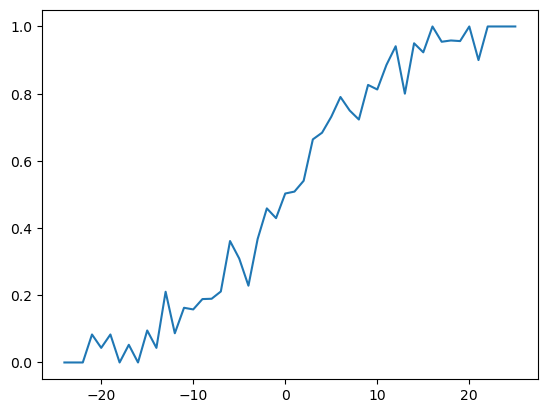

In [67]:
# plot predicted win percentage
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0)})
plot_df["pred_int"] = plot_df["pred"].astype(int)
plot_df = plot_df.groupby('pred_int')['label'].mean().reset_index(name='average_win_pct')

plt.figure()
plt.plot(plot_df.pred_int,plot_df.average_win_pct)

In [68]:
# create spline model to smooth predictions
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
        
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    
    print(f"logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}") 

logloss of cvsplit 0: 0.5574811940679258
logloss of cvsplit 1: 0.554241689481722
logloss of cvsplit 2: 0.5574411362716198
logloss of cvsplit 3: 0.5552936423166025
logloss of cvsplit 4: 0.5553500887317964
logloss of cvsplit 5: 0.5550750078010754
logloss of cvsplit 6: 0.5560374846230651
logloss of cvsplit 7: 0.5574647387594985
logloss of cvsplit 8: 0.5535692504395469
logloss of cvsplit 9: 0.5564375355408794


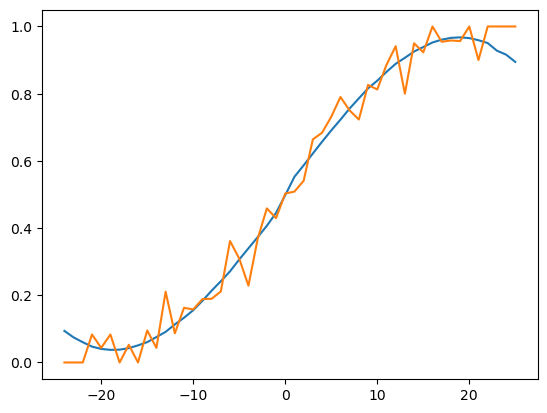

In [69]:
# plot spline model over xgb predictions
plot_df = pd.DataFrame({"pred":oof_preds[0], "label":np.where(y>0,1,0), "spline":spline_model[0](oof_preds[0])})
plot_df["pred_int"] = (plot_df["pred"]).astype(int)
plot_df = plot_df.groupby('pred_int')[['spline','label']].mean().reset_index()

plt.figure()
plt.plot(plot_df.pred_int,plot_df.spline)
plt.plot(plot_df.pred_int,plot_df.label)

In [70]:
# recalculate spline model with range of probability 0.025-0.975
spline_model = []

for i in range(repeat_cv):
    dat = list(zip(oof_preds[i],np.where(y>0,1,0)))
    dat = sorted(dat, key = lambda x: x[0])
    datdict = {}
    for k in range(len(dat)):
        datdict[dat[k][0]]= dat[k][1]
    spline_model.append(UnivariateSpline(list(datdict.keys()), list(datdict.values())))
    spline_fit = spline_model[i](oof_preds[i])
    spline_fit = np.clip(spline_fit,0.025,0.975)
    
    print(f"adjusted logloss of cvsplit {i}: {log_loss(np.where(y>0,1,0),spline_fit)}")

adjusted logloss of cvsplit 0: 0.5574811940679258
adjusted logloss of cvsplit 1: 0.554241689481722
adjusted logloss of cvsplit 2: 0.5574424731900578
adjusted logloss of cvsplit 3: 0.5552936423166025
adjusted logloss of cvsplit 4: 0.5553500887317964
adjusted logloss of cvsplit 5: 0.5550750078010754
adjusted logloss of cvsplit 6: 0.5560374846230651
adjusted logloss of cvsplit 7: 0.5574647387594985
adjusted logloss of cvsplit 8: 0.5535517843559448
adjusted logloss of cvsplit 9: 0.5564375355408794


# Submission

In [71]:
sub = pd.read_csv("data/SampleSubmissionStage2.csv")
sub['Season'] = sub['ID'].apply(lambda x: int(x.split('_')[0]))
sub["T1_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[1]))
sub["T2_TeamID"] = sub['ID'].apply(lambda x: int(x.split('_')[2]))
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID
0,2025_1101_1102,0.5,2025,1101,1102
1,2025_1101_1103,0.5,2025,1101,1103
2,2025_1101_1104,0.5,2025,1101,1104
3,2025_1101_1105,0.5,2025,1101,1105
4,2025_1101_1106,0.5,2025,1101,1106


In [72]:
sub['TeamSeasonID'] = sub['T1_TeamID'].astype(str) + "_" + sub['Season'].astype(str)
sub['Opp_TeamSeasonID'] = sub['T2_TeamID'].astype(str) + "_" + sub['Season'].astype(str)

# filter to men's teams
sub = sub[(sub['T1_TeamID'] < 2500) & (sub['T2_TeamID'] < 2500)]

# regular season
sub = pd.merge(sub, m_feat, on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, m_feat, left_on = 'Opp_TeamSeasonID', right_on= 'TeamSeasonID', how = 'left', suffixes=[None,'_Opp'])
sub.drop(columns=['TeamSeasonID_Opp'], inplace=True)

# team quality
sub = pd.merge(sub, glm_quality[['TeamSeasonID', 'quality']], on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, glm_quality[['Opp_TeamSeasonID', 'Opp_quality']], on = 'Opp_TeamSeasonID', how = 'left')

# tournament seeds
sub = pd.merge(sub, seeds_T1, on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, seeds_T2, on = 'Opp_TeamSeasonID', how = 'left')
sub['seed_diff'] = sub['seed'] - sub['Opp_seed']

# last 14 days
sub = pd.merge(sub, last14days_stats_T1, on = 'TeamSeasonID', how = 'left')
sub = pd.merge(sub, last14days_stats_T2, on = 'Opp_TeamSeasonID', how = 'left')

sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,TeamSeasonID,Opp_TeamSeasonID,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp,Pts_Opp,Opp_Pts_Opp,NumOT_Opp,FGM_Opp,FGA_Opp,FGM3_Opp,FGA3_Opp,FTM_Opp,FTA_Opp,OR_Opp,DR_Opp,Ast_Opp,TO_Opp,Stl_Opp,Blk_Opp,PF_Opp,Opp_FGM_Opp,Opp_FGA_Opp,Opp_FGM3_Opp,Opp_FGA3_Opp,Opp_FTM_Opp,Opp_FTA_Opp,Opp_OR_Opp,Opp_DR_Opp,Opp_Ast_Opp,Opp_TO_Opp,Opp_Stl_Opp,Opp_Blk_Opp,Opp_PF_Opp,Margin_Opp,FGp_Opp,FG3p_Opp,FTp_Opp,TR_Opp,Opp_FGp_Opp,Opp_FG3p_Opp,Opp_FTp_Opp,Opp_TR_Opp,ORp_Opp,DRp_Opp,Opp_ORp_Opp,Opp_DRp_Opp,FGA3p_Opp,Opp_FGA3p_Opp,Ast_p_Opp,Opp_Ast_p_Opp,TO_p_Opp,Opp_TO_p_Opp,Pos_Opp,Opp_Pos_Opp,Blk_p_Opp,Opp_Blk_p_Opp,TSp_Opp,Opp_TSp_Opp,quality,Opp_quality,seed,Opp_seed,seed_diff,win_ratio_14d,Opp_win_ratio_14d
0,2025_1101_1102,0.5,2025,1101,1102,1101_2025,1102_2025,67.551724,71.0,0.068966,24.206897,56.241379,4.103448,14.206897,15.034483,20.896552,8.655172,19.586207,12.482759,14.206897,10.034483,2.896552,21.448276,23.655172,51.310345,5.448276,16.689655,18.241379,26.344828,8.758621,22.586207,12.206897,16.034483,7.896552,4.689655,17.724138,-3.448276,0.430411,0.288835,0.719472,28.241379,0.461022,0.326446,0.692408,31.344828,0.153893,0.38172,0.170699,0.401594,0.252606,0.325269,0.51567,0.516035,0.21303,0.248663,80.896552,80.517241,0.056452,0.083384,0.516167,0.564369,61.937500,73.656250,0.062500,21.250000,50.500000,8.093750,24.468750,11.343750,17.875000,5.937500,20.937500,13.375000,12.187500,5.656250,2.843750,17.843750,26.406250,54.937500,7.218750,19.906250,13.625000,19.468750,7.937500,23.906250,12.843750,9.687500,6.812500,3.218750,17.437500,-11.718750,0.420792,0.330779,0.634615,26.875000,0.480660,0.362637,0.699839,31.843750,0.117574,0.381115,0.144482,0.473391,0.484530,0.362344,0.629412,0.486391,0.205047,0.149795,71.625000,74.359375,0.051763,0.063738,0.530605,0.579936,-1.498801e-15,-1.397203,NaN,NaN,NaN,0.333333,0.0
1,2025_1101_1103,0.5,2025,1101,1103,1101_2025,1103_2025,67.551724,71.0,0.068966,24.206897,56.241379,4.103448,14.206897,15.034483,20.896552,8.655172,19.586207,12.482759,14.206897,10.034483,2.896552,21.448276,23.655172,51.310345,5.448276,16.689655,18.241379,26.344828,8.758621,22.586207,12.206897,16.034483,7.896552,4.689655,17.724138,-3.448276,0.430411,0.288835,0.719472,28.241379,0.461022,0.326446,0.692408,31.344828,0.153893,0.38172,0.170699,0.401594,0.252606,0.325269,0.51567,0.516035,0.21303,0.248663,80.896552,80.517241,0.056452,0.083384,0.516167,0.564369,83.968750,75.906250,0.031250,30.218750,64.125000,10.656250,29.093750,12.875000,17.187500,9.968750,24.875000,17.687500,11.750000,7.562500,3.718750,18.281250,26.687500,61.375000,7.437500,23.343750,15.093750,20.687500,8.843750,21.625000,11.937500,12.000000,7.187500,2.437500,16.812500,8.062500,0.471248,0.366273,0.749091,34.843750,0.434827,0.318608,0.729607,30.468750,0.155458,0.405295,0.144094,0.337232,0.453704,0.380346,0.585315,0.447307,0.161581,0.167320,84.468750,83.718750,0.060591,0.038012,0.585658,0.538514,-1.498801e-15,1.989407,NaN,13.0,NaN,0.333333,1.0
2,2025_1101_1104,0.5,2025,1101,1104,1101_2025,1104_2025,67.551724,71.0,0.068966,24.206897,56.241379,4.103448,14.206897,15.034483,20.896552,8.655172,19.586207,12.482759,14.206897,10.034483,2.896552,21.448276,23.655172,51.310345,5.448276,16.689655,18.241379,26.344828,8.758621,22.586207,12.206897,16.034483,7.896552,4.689655,17.724138,-3.448276,0.430411,0.288835,0.719472,28.241379,0.461022,0.326446,0.692408,31.344828,0.153893,0.38172,0.170699,0.401594,0.252606,0.325269,0.51567,0.516035,0.21303,0.248663,80.896552,80.517241,0.056452,0.083384,0.516167,0.564369,91.121212,81.424242,0.060606,31.090909,64.424242,10.424242,29.787879,18.515152,25.848485,10.969697,28.363636,16.787879,12.121212,6.060606,4.454545,19.030303,28.909091,68.09

In [73]:
# get sub features
Xsub = sub.iloc[:,7:].values
dtest = xgb.DMatrix(Xsub)

In [74]:
# building cv models for submission
sub_models = []
for i in range(repeat_cv):
    print(f"Fold repeater {i}")
    sub_models.append(
        xgb.train(
          params = param,
          dtrain = d_train,
          num_boost_round = int(iteration_counts[i] * 1.05),
          verbose_eval = 50
        )
    )

Fold repeater 0
Fold repeater 1
Fold repeater 2
Fold repeater 3
Fold repeater 4
Fold repeater 5
Fold repeater 6
Fold repeater 7
Fold repeater 8
Fold repeater 9


In [75]:
sub_preds = []
for i in range(repeat_cv):
    sub_preds.append(np.clip(spline_model[i](np.clip(sub_models[i].predict(dtest),-30,30)),0.025,0.975))
    
sub["Pred"] = pd.DataFrame(sub_preds).mean(axis=0)

# in previous competitions, some people have hard-coded against upsets
"""
sub.loc[(sub.T1_seed==1) & (sub.T2_seed==16), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==2) & (sub.T2_seed==15), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==3) & (sub.T2_seed==14), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==4) & (sub.T2_seed==13), 'Pred'] = 1.0
sub.loc[(sub.T1_seed==16) & (sub.T2_seed==1), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==15) & (sub.T2_seed==2), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==14) & (sub.T2_seed==3), 'Pred'] = 0.0
sub.loc[(sub.T1_seed==13) & (sub.T2_seed==4), 'Pred'] = 0.0
"""

sub[['ID','Pred']].to_csv("submissions/m_submission.csv", index = None)

In [76]:
# preview submissions df
sub.head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,TeamSeasonID,Opp_TeamSeasonID,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp,Pts_Opp,Opp_Pts_Opp,NumOT_Opp,FGM_Opp,FGA_Opp,FGM3_Opp,FGA3_Opp,FTM_Opp,FTA_Opp,OR_Opp,DR_Opp,Ast_Opp,TO_Opp,Stl_Opp,Blk_Opp,PF_Opp,Opp_FGM_Opp,Opp_FGA_Opp,Opp_FGM3_Opp,Opp_FGA3_Opp,Opp_FTM_Opp,Opp_FTA_Opp,Opp_OR_Opp,Opp_DR_Opp,Opp_Ast_Opp,Opp_TO_Opp,Opp_Stl_Opp,Opp_Blk_Opp,Opp_PF_Opp,Margin_Opp,FGp_Opp,FG3p_Opp,FTp_Opp,TR_Opp,Opp_FGp_Opp,Opp_FG3p_Opp,Opp_FTp_Opp,Opp_TR_Opp,ORp_Opp,DRp_Opp,Opp_ORp_Opp,Opp_DRp_Opp,FGA3p_Opp,Opp_FGA3p_Opp,Ast_p_Opp,Opp_Ast_p_Opp,TO_p_Opp,Opp_TO_p_Opp,Pos_Opp,Opp_Pos_Opp,Blk_p_Opp,Opp_Blk_p_Opp,TSp_Opp,Opp_TSp_Opp,quality,Opp_quality,seed,Opp_seed,seed_diff,win_ratio_14d,Opp_win_ratio_14d
0,2025_1101_1102,0.310714,2025,1101,1102,1101_2025,1102_2025,67.551724,71.0,0.068966,24.206897,56.241379,4.103448,14.206897,15.034483,20.896552,8.655172,19.586207,12.482759,14.206897,10.034483,2.896552,21.448276,23.655172,51.310345,5.448276,16.689655,18.241379,26.344828,8.758621,22.586207,12.206897,16.034483,7.896552,4.689655,17.724138,-3.448276,0.430411,0.288835,0.719472,28.241379,0.461022,0.326446,0.692408,31.344828,0.153893,0.38172,0.170699,0.401594,0.252606,0.325269,0.51567,0.516035,0.21303,0.248663,80.896552,80.517241,0.056452,0.083384,0.516167,0.564369,61.937500,73.656250,0.062500,21.250000,50.500000,8.093750,24.468750,11.343750,17.875000,5.937500,20.937500,13.375000,12.187500,5.656250,2.843750,17.843750,26.406250,54.937500,7.218750,19.906250,13.625000,19.468750,7.937500,23.906250,12.843750,9.687500,6.812500,3.218750,17.437500,-11.718750,0.420792,0.330779,0.634615,26.875000,0.480660,0.362637,0.699839,31.843750,0.117574,0.381115,0.144482,0.473391,0.484530,0.362344,0.629412,0.486391,0.205047,0.149795,71.625000,74.359375,0.051763,0.063738,0.530605,0.579936,-1.498801e-15,-1.397203,NaN,NaN,NaN,0.333333,0.0
1,2025_1101_1103,0.197580,2025,1101,1103,1101_2025,1103_2025,67.551724,71.0,0.068966,24.206897,56.241379,4.103448,14.206897,15.034483,20.896552,8.655172,19.586207,12.482759,14.206897,10.034483,2.896552,21.448276,23.655172,51.310345,5.448276,16.689655,18.241379,26.344828,8.758621,22.586207,12.206897,16.034483,7.896552,4.689655,17.724138,-3.448276,0.430411,0.288835,0.719472,28.241379,0.461022,0.326446,0.692408,31.344828,0.153893,0.38172,0.170699,0.401594,0.252606,0.325269,0.51567,0.516035,0.21303,0.248663,80.896552,80.517241,0.056452,0.083384,0.516167,0.564369,83.968750,75.906250,0.031250,30.218750,64.125000,10.656250,29.093750,12.875000,17.187500,9.968750,24.875000,17.687500,11.750000,7.562500,3.718750,18.281250,26.687500,61.375000,7.437500,23.343750,15.093750,20.687500,8.843750,21.625000,11.937500,12.000000,7.187500,2.437500,16.812500,8.062500,0.471248,0.366273,0.749091,34.843750,0.434827,0.318608,0.729607,30.468750,0.155458,0.405295,0.144094,0.337232,0.453704,0.380346,0.585315,0.447307,0.161581,0.167320,84.468750,83.718750,0.060591,0.038012,0.585658,0.538514,-1.498801e-15,1.989407,NaN,13.0,NaN,0.333333,1.0
2,2025_1101_1104,0.266722,2025,1101,1104,1101_2025,1104_2025,67.551724,71.0,0.068966,24.206897,56.241379,4.103448,14.206897,15.034483,20.896552,8.655172,19.586207,12.482759,14.206897,10.034483,2.896552,21.448276,23.655172,51.310345,5.448276,16.689655,18.241379,26.344828,8.758621,22.586207,12.206897,16.034483,7.896552,4.689655,17.724138,-3.448276,0.430411,0.288835,0.719472,28.241379,0.461022,0.326446,0.692408,31.344828,0.153893,0.38172,0.170699,0.401594,0.252606,0.325269,0.51567,0.516035,0.21303,0.248663,80.896552,80.517241,0.056452,0.083384,0.516167,0.564369,91.121212,81.424242,0.060606,31.090909,64.424242,10.424242,29.787879,18.515152,25.848485,10.969697,28.363636,16.787879,12.121212,6.060606,4.454545,19.030303,

In [ ]:
# create another submission with hard-coding against first-round upsets

"""
in previous competitions, some people have hard-coded against upsets
I'm only doing 1, 2, and 3 seeds
"""

sub.loc[(sub.seed==1) & (sub.Opp_seed==16), 'Pred'] = 1.0
sub.loc[(sub.seed==2) & (sub.Opp_seed==15), 'Pred'] = 1.0
sub.loc[(sub.seed==3) & (sub.Opp_seed==14), 'Pred'] = 1.0
#sub.loc[(sub.seed==4) & (sub.Opp_seed==13), 'Pred'] = 1.0
sub.loc[(sub.seed==16) & (sub.Opp_seed==1), 'Pred'] = 0.0
sub.loc[(sub.seed==15) & (sub.Opp_seed==2), 'Pred'] = 0.0
sub.loc[(sub.seed==14) & (sub.Opp_seed==3), 'Pred'] = 0.0
# sub.loc[(sub.seed==13) & (sub.Opp_seed==4), 'Pred'] = 0.0

sub[['ID','Pred']].to_csv("submissions/m_submission_chalk.csv", index = None)

In [213]:
sub.loc[(sub.seed==1) & (sub.Opp_seed==16), :].head()

,ID,Pred,Season,T1_TeamID,T2_TeamID,TeamSeasonID,Opp_TeamSeasonID,Pts,Opp_Pts,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,Opp_FGM,Opp_FGA,Opp_FGM3,Opp_FGA3,Opp_FTM,Opp_FTA,Opp_OR,Opp_DR,Opp_Ast,Opp_TO,Opp_Stl,Opp_Blk,Opp_PF,Margin,FGp,FG3p,FTp,TR,Opp_FGp,Opp_FG3p,Opp_FTp,Opp_TR,ORp,DRp,Opp_ORp,Opp_DRp,FGA3p,Opp_FGA3p,Ast_p,Opp_Ast_p,TO_p,Opp_TO_p,Pos,Opp_Pos,Blk_p,Opp_Blk_p,TSp,Opp_TSp,Pts_Opp,Opp_Pts_Opp,NumOT_Opp,FGM_Opp,FGA_Opp,FGM3_Opp,FGA3_Opp,FTM_Opp,FTA_Opp,OR_Opp,DR_Opp,Ast_Opp,TO_Opp,Stl_Opp,Blk_Opp,PF_Opp,Opp_FGM_Opp,Opp_FGA_Opp,Opp_FGM3_Opp,Opp_FGA3_Opp,Opp_FTM_Opp,Opp_FTA_Opp,Opp_OR_Opp,Opp_DR_Opp,Opp_Ast_Opp,Opp_TO_Opp,Opp_Stl_Opp,Opp_Blk_Opp,Opp_PF_Opp,Margin_Opp,FGp_Opp,FG3p_Opp,FTp_Opp,TR_Opp,Opp_FGp_Opp,Opp_FG3p_Opp,Opp_FTp_Opp,Opp_TR_Opp,ORp_Opp,DRp_Opp,Opp_ORp_Opp,Opp_DRp_Opp,FGA3p_Opp,Opp_FGA3p_Opp,Ast_p_Opp,Opp_Ast_p_Opp,TO_p_Opp,Opp_TO_p_Opp,Pos_Opp,Opp_Pos_Opp,Blk_p_Opp,Opp_Blk_p_Opp,TSp_Opp,Opp_TSp_Opp,quality,Opp_quality,seed,Opp_seed,seed_diff,win_ratio_14d,Opp_win_ratio_14d
6098,2025_1120_1188,1.0,2025,1120,1188,1120_2025,1188_2025,83.848485,69.606061,0.030303,29.696970,61.545455,9.181818,24.969697,15.272727,20.636364,10.181818,23.939394,16.484848,8.909091,6.969697,6.181818,18.606061,23.575758,57.606061,5.848485,20.030303,16.606061,22.606061,8.909091,20.363636,9.454545,11.090909,6.060606,2.727273,17.515152,14.242424,0.482521,0.367718,0.740088,34.121212,0.409258,0.291982,0.734584,29.272727,0.165436,0.415571,0.154655,0.330871,0.405711,0.347712,0.555102,0.401028,0.123972,0.160950,80.772727,80.000000,0.107312,0.044313,0.593614,0.515198,70.600000,67.966667,0.066667,25.100000,58.666667,7.233333,21.266667,13.166667,19.400000,9.566667,24.033333,12.900000,10.833333,6.266667,4.066667,16.800000,23.633333,57.400000,7.300000,22.133333,13.400000,19.066667,8.566667,23.466667,11.500000,10.900000,6.600000,3.000000,16.933333,2.633333,0.427841,0.340125,0.678694,33.600000,0.411731,0.329819,0.702797,32.033333,0.163068,0.418699,0.149245,0.400000,0.362500,0.385598,0.513944,0.486601,0.158459,0.162849,79.200000,77.833333,0.070848,0.051136,0.525277,0.516548,6.491702,-0.115644,1.0,16.0,-15.0,0.25,1.0
6198,2025_1120_1291,1.0,2025,1120,1291,1120_2025,1291_2025,83.848485,69.606061,0.030303,29.696970,61.545455,9.181818,24.969697,15.272727,20.636364,10.181818,23.939394,16.484848,8.909091,6.969697,6.181818,18.606061,23.575758,57.606061,5.848485,20.030303,16.606061,22.606061,8.909091,20.363636,9.454545,11.090909,6.060606,2.727273,17.515152,14.242424,0.482521,0.367718,0.740088,34.121212,0.409258,0.291982,0.734584,29.272727,0.165436,0.415571,0.154655,0.330871,0.405711,0.347712,0.555102,0.401028,0.123972,0.160950,80.772727,80.000000,0.107312,0.044313,0.593614,0.515198,69.515152,70.030303,0.121212,24.454545,55.727273,7.969697,22.848485,12.636364,17.303030,8.666667,25.393939,14.818182,14.212121,5.969697,2.666667,15.727273,24.818182,60.515152,8.454545,26.939394,11.939394,16.181818,9.272727,21.363636,12.969697,10.242424,8.757576,3.121212,16.090909,-0.515152,0.438825,0.348806,0.730298,34.060606,0.410115,0.313836,0.737828,30.636364,0.155519,0.419629,0.153230,0.383361,0.410005,0.445168,0.605948,0.522589,0.220758,0.149293,78.590909,78.848485,0.044066,0.056009,0.548741,0.517706,6.491702,0.321622,1.0,16.0,-15.0,0.25,0.8
6219,2025_1120_1313,1.0,2025,1120,1313,1120_2025,1313_2025,83.848485,69.606061,0.030303,29.696970,61.545455,9.181818,24.969697,15.272727,20.636364,10.181818,23.939394,16.484848,8.909091,6.969697,6.181818,18.606061,23.575758,57.606061,5.848485,20.030303,16.606061,22.606061,8.909091,20.363636,9.454545,11.090909,6.060606,2.727273,17.515152,14.242424,0.482521,0.367718,0.740088,34.121212,0.409258,0.291982,0.734584,29.272727,0.165436,0.415571,0.154655,0.330871,0.405711,0.347712,0.555102,0.401028,0.123972,0.160950,80.772727,80.000000,0.107312,0.044313,0.593614,0.515198,74.903226,71.032258,0.064516,26.838710,55.838710,4.838710,15.483871,16.387097,21.774194,8.225806,21.645161,13.225806,11.709677,6.419355,2.935484,17.548387,24.2

# Future improvements

- Even more feature engineering: conferences, massey ordinals, coaches. There are definitely some teams the model loves because of their performance against lesser competition. Also really interested to dissect why this thing *hates* Bama.
- hyperparameter tuning: not sure how much performance I could get out of this size of dataset, on top of the CV and spline modeling, but I could grid search for HPs
- boosting odds against first-round upsets rather than hard-coding 100% probability